# **IMPORTS**

In [2]:
!pip install transformers datasets 

In [27]:
from datasets import load_dataset
import transformers
import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns

# **DATA**

In [30]:
ds = load_dataset("OpenAssistant/oasst1")

print(ds['train'])
print(ds['validation'])

Dataset({
    features: ['message_id', 'parent_id', 'user_id', 'created_date', 'text', 'role', 'lang', 'review_count', 'review_result', 'deleted', 'rank', 'synthetic', 'model_name', 'detoxify', 'message_tree_id', 'tree_state', 'emojis', 'labels'],
    num_rows: 84437
})
Dataset({
    features: ['message_id', 'parent_id', 'user_id', 'created_date', 'text', 'role', 'lang', 'review_count', 'review_result', 'deleted', 'rank', 'synthetic', 'model_name', 'detoxify', 'message_tree_id', 'tree_state', 'emojis', 'labels'],
    num_rows: 4401
})


<h3>Фильтруем датасет по <em>top-level инструкциям на русском языке</em> (инструкции, с которых начинался диалог <strong>(parent_id = None)</strong>
    и соответственно <strong>роль - prompter</strong>, так как человек начинает диалог с языковой моделью</h3>

In [58]:
russian_ds_train = ds['train'].filter(lambda sample: sample['lang'] == 'ru' and sample['role'] == 'prompter' and ((sample['parent_id'] is None) or sample['parent_id'] == ''))
russian_ds_val = ds['validation'].filter(lambda sample: sample['lang'] == 'ru' and sample['role'] == 'prompter' and ((sample['parent_id'] is None) or sample['parent_id'] == ''))

df_russian_train = pd.DataFrame(russian_ds_train)
df_russian_val = pd.DataFrame(russian_ds_val)

df_russian_samples = pd.concat([df_russian_train, df_russian_val], ignore_index=True)

print(f"Количество top-level инструкций на русском языке: {len(df_russian_samples)}")

Количество top-level инструкций на русском языке: 760


<p>Из <strong>9089</strong> сообщений на русском языке из этого датасета лишь <strong>760</strong> являются <em>top-level инструкциями</em></p>

In [54]:
df_russian_samples.info()
df_russian_samples.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   message_id       760 non-null    object
 1   parent_id        0 non-null      object
 2   user_id          760 non-null    object
 3   created_date     760 non-null    object
 4   text             760 non-null    object
 5   role             760 non-null    object
 6   lang             760 non-null    object
 7   review_count     760 non-null    int64 
 8   review_result    760 non-null    bool  
 9   deleted          760 non-null    bool  
 10  rank             0 non-null      object
 11  synthetic        760 non-null    bool  
 12  model_name       0 non-null      object
 13  detoxify         760 non-null    object
 14  message_tree_id  760 non-null    object
 15  tree_state       760 non-null    object
 16  emojis           760 non-null    object
 17  labels           760 non-null    ob

,message_id,parent_id,user_id,created_date,text,role,lang,review_count,review_result,deleted,rank,synthetic,model_name,detoxify,message_tree_id,tree_state,emojis,labels
0,e480f611-0d31-433a-93d2-0e2bc675aa30,None,05a999f8-8219-4584-a3f2-d4b4aec30027,2023-02-06T23:09:05.356836+00:00,Напиши информацию о игре Hytale,prompter,ru,3,True,False,None,False,None,"{'toxicity': 0.0008757906034588814, 'severe_to...",e480f611-0d31-433a-93d2-0e2bc675aa30,ready_for_export,"{'name': ['+1', '_skip_ranking', '_skip_labeli...","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
1,fa8c92d6-6daa-42a3-a2f5-e2e0eb610c41,None,19241e3c-8272-4c3f-afe8-527c005d042c,2023-02-07T14:36:48.863674+00:00,"Докончи поговорку, без труда не выловишь и",prompter,ru,3,True,False,None,False,None,"{'toxicity': 0.0432540699839592, 'severe_toxic...",fa8c92d6-6daa-42a3-a2f5-e2e0eb610c41,ready_for_export,"{'name': ['+1', '-1'], 'count': [3, 1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
2,ef69d986-aa2d-4c3e-a122-1910d9625c79,None,6b1efbfa-7c16-47bf-b90c-340ab2b1b7eb,2023-02-08T14:59:45.846381+00:00,"У меня угнали машину, что мне делать?",prompter,ru,3,True,False,None,False,None,"{'toxicity': 0.004925671499222517, 'severe_tox...",ef69d986-aa2d-4c3e-a122-1910d9625c79,ready_for_export,"{'name': ['+1', '_skip_reply'], 'count': [4, 1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."


# **DATA VISUALIZATION**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


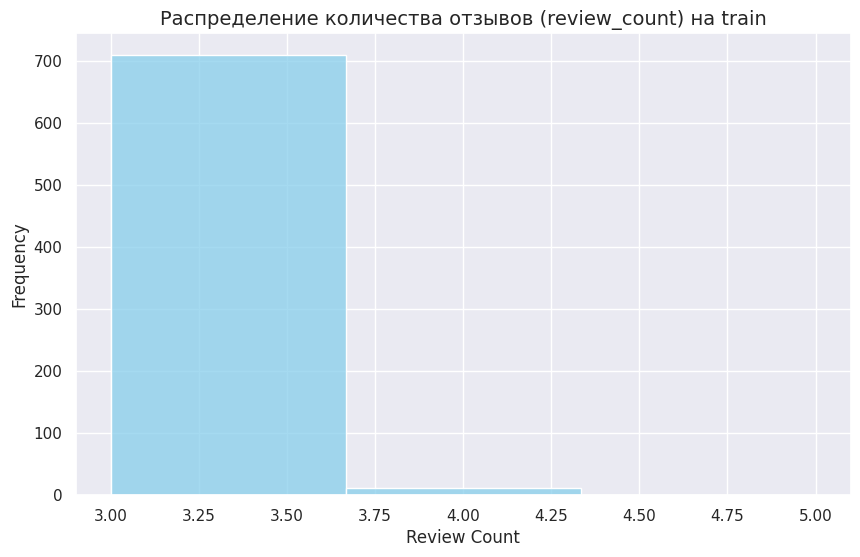

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


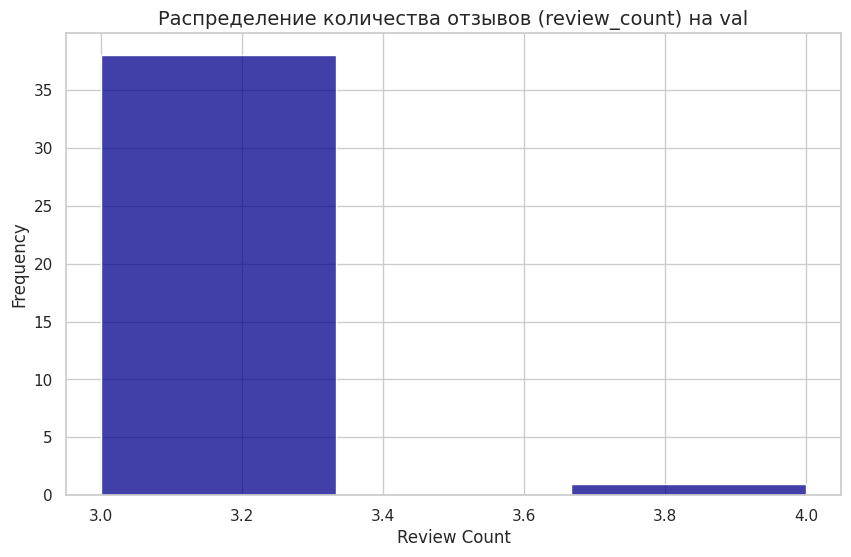

In [59]:
sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_russian_train['review_count'], bins=3, kde=False, color='skyblue')
plt.title('Распределение количества отзывов (review_count) на train', fontsize=14)
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.show()

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_russian_val['review_count'], bins=3, kde=False, color='darkblue')
plt.title('Распределение количества отзывов (review_count) на val', fontsize=14)
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.show()

#основное количество отзывов равно 3, малая часть сообщений имеет количество отзывов = 4

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


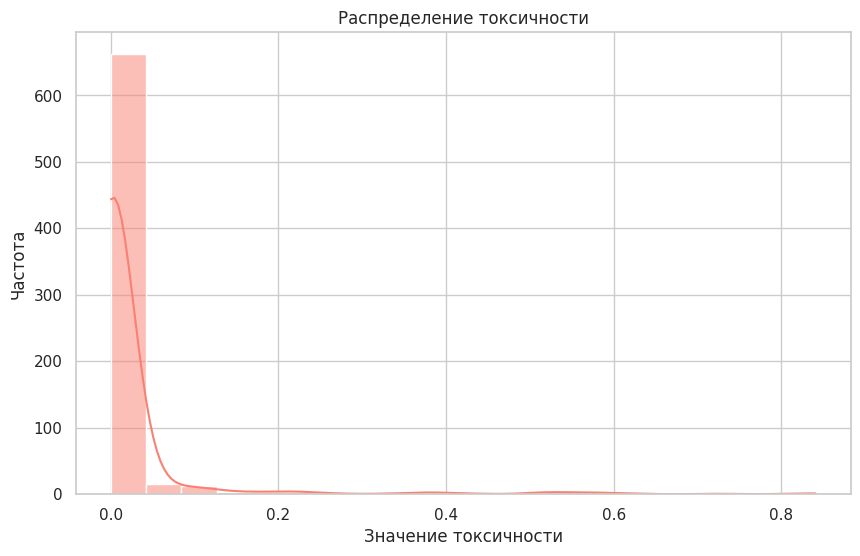

In [69]:
df_russian_train['toxicity'] = df_russian_train['detoxify'].apply(lambda x: x.get('toxicity', 0))

plt.figure(figsize=(10, 6))
sns.histplot(df_russian_train['toxicity'], bins=20, kde=True, color='salmon')
plt.title('Распределение токсичности во всём отфильтрованном датасете')
plt.xlabel('Значение токсичности')
plt.ylabel('Частота')
plt.show()
#токсичность большинства сообщений крайне низкая. Количество сообщений с высокими значениями токсичности близится к нулю

In [65]:
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

word_freq = Counter()
df_russian_samples['text'].apply(lambda x: word_freq.update(tokenize(x)))

print(word_freq.most_common(10))


[('в', 309), ('и', 296), ('на', 214), ('что', 208), ('как', 207), ('не', 145), ('я', 131), ('с', 110), ('ты', 101), ('для', 100)]


In [60]:
df_russian_samples.to_csv("ru_samples.csv", index=False)
df_russian_train.to_csv("ru_samples_train.csv", index=False)
df_russian_val.to_csv("ru_samples_val.csv", index=False)